# PHAS0056 Practical Machine Learning for Physicists Mini Project

# Sound Identification

In this mini project we have been given the following tasks:

1. Develop a machine learning algorithm that can classify the sounds in terms of the 50 original categories using only the spectrogram images.
2. Develop a machine learning algorithm that can classify the sounds in terms of the 50 original categories using only the waveforms.
3. Determine which of the categories are easiest and hardest to separate.

These are the potential extension tasks:

1. Use an appropriate technique to determine how to group the 50 categories into a smaller number of super-categories
2. Develop a machine learning algorithm that can classify the sounds in terms of the super categories
3. Record some sounds of your own (or find suitable sounds otherwise) and test how well your model can categorise the new sounds.
4. Develop a generative network that can create fake sounds from one or more of the categories.

In [1]:
#Importing required modules

import librosa
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm

import tensorflow as tf
from tensorflow import keras

from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from skimage.transform import resize
from sklearn.manifold import TSNE
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix

import seaborn as sb

In [2]:
#These functions were originally here (Project Group J - Identifying Sounds Notebook)

def getMeta():
    
    """
    This function gets the meta data from the sounds.csv file.
    
    Returns:
        pandas.DataFrame : A dataframe storing the meta data from the sounds.csv file.
    """
    
    return pd.read_csv('meta/sounds.csv')

def getSignal(fileName):
    
    """
    This function returns the waveform from a given audio file.
    
    Parameters:
        filename : string : The name of the audio file.
        
    Returns:
        array : An array storing the waveform data from a given audio file.
    """
    
    return librosa.load(fileName, sr=44100)[0]

def getSpect(signal):
    
    """
    This function returns the spectrogram representation of a given audio waveform.
    
    Parameters:
        signal : array : An array of waveform data.
        
    Returns:
        spec : array : An array of spectrogram data.
    """
    
    spec = librosa.feature.melspectrogram(y=signal, sr=44100, n_fft=2205, hop_length=441)
    spec = librosa.power_to_db(spec)
    
    return spec

def getSignalSpect(meta, number):
    
    """
    This function returns both the waveform and spectrogram data from a given audio file selected by number.
    
    Parameters:
        meta   : pandas.DataFrame : A dataframe storing the meta data from the sounds.csv file.
        number : int              : The file number.
        
    Returns:
        signal           : array : An array of waveform data.
        getSpect(signal) : array : An array of spectrogram data.
    """
    
    recording = meta['filename'][number]
    signal = getSignal('audio/' + recording)
    
    return signal, getSpect(signal)

meta = getMeta()

In [3]:
#The data stored in the sounds.csv file
meta

,filename,fold,target,category,esc10,src_file,take
0,1-100032-A-0.wav,1,0,dog,True,100032,A
1,1-100038-A-14.wav,1,14,chirping_birds,False,100038,A
2,1-100210-A-36.wav,1,36,vacuum_cleaner,False,100210,A
3,1-100210-B-36.wav,1,36,vacuum_cleaner,False,100210,B
4,1-101296-A-19.wav,1,19,thunderstorm,False,101296,A
...,...,...,...,...,...,...,...
1995,5-263831-B-6.wav,5,6,hen,False,263831,B
1996,5-263902-A-36.wav,5,36,vacuum_cleaner,False,263902,A
1997,5-51149-A-25.wav,5,25,footsteps,False,51149,A
1998,5-61635-A-8.wav,5,8,sheep,False,61635,A


# Project Tasks
For the machine learning tasks we are tasked to develop a machine learning algorithm that can classify the sounds in terms of the 50 original categories using only the spectrogram image and waveforms. Then we have to determine which of the categories are easiest and hardest to separate.

## Task 1
In this task we have to develop a machine learning algorithm to classify sounds from the ESC-50 dataset into 50 categories using spectrograms. The spectrograms are produced from the frequency-time data using the librosa python module.

Im going to treat the spectrograms as images and use a convolutional neural network to classify them into 50 categories.

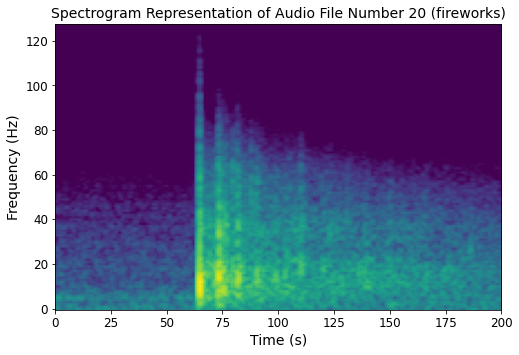

In [4]:
#Plotting the spectrogram representation of audio file number 20

signal, spec = getSignalSpect(meta, 20)
fig, ax = plt.subplots(figsize=(8, 8))
ax.tick_params(axis='x', labelsize=12)
ax.tick_params(axis='y', labelsize=12)

ax.imshow(spec, origin='lower', interpolation=None, cmap='viridis', aspect=1)
ax.set_title("Spectrogram Representation of Audio File Number 20 (" + meta.category[20] + ")", fontsize=14)
ax.set_xlabel("Time (s)", fontsize=14)
ax.set_xlim(0, 200)
ax.set_ylabel("Frequency (Hz)", fontsize=14);

#plt.savefig("Spectrogram.pdf", dpi=600, bbox_inches='tight')

In [5]:
#Populating data array with resized and normalised spectrogram data

data = np.zeros((2000, 128, 128))

for i in tqdm(range(0, 2000)):
    spec = resize(preprocessing.normalize(getSignalSpect(meta, i)[1]), (128, 128))
    data[i] = spec

100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:42<00:00, 47.49it/s]


In [6]:
#Initialsing labels array
labels = np.concatenate((np.array(meta.target), np.array(meta.target)), axis=0)

#Creating data with noise
noisy_data = data + np.random.uniform(0, 0.1, data.shape)
new_data = np.concatenate((data, noisy_data), axis=0)

#Generating training and testing data
train_data, test_data, train_labels, test_labels = train_test_split(new_data, labels, test_size=0.20, shuffle=True)

In [7]:
#Defining a 2D-CNN model to classify the spectrogams into 50 categories

model = keras.Sequential([
    keras.layers.Input(shape=(128, 128, 1)),
    keras.layers.Resizing(64, 64),

    keras.layers.Conv2D(16, (3, 3)),
    keras.layers.LeakyReLU(),
    keras.layers.MaxPooling2D((2, 2)),

    keras.layers.Conv2D(32, (3, 3)),
    keras.layers.LeakyReLU(),
    keras.layers.MaxPooling2D((2, 2)),

    keras.layers.Conv2D(64, (3, 3)),
    keras.layers.LeakyReLU(),
    keras.layers.MaxPooling2D((2, 2)),

    keras.layers.Dropout(0.25),

    keras.layers.Flatten(),

    keras.layers.Dense(128),
    keras.layers.LeakyReLU(),

    keras.layers.Dropout(0.5),

    keras.layers.Dense(50)
])

#Compiling the model with a sparse categorical cross-entropy loss
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), optimizer=keras.optimizers.Adam(learning_rate=1e-3), metrics=["accuracy"])

#Training the model for 20 epochs and a batchsize of 5
history = model.fit(train_data, train_labels, epochs=20, batch_size=5, validation_data=(test_data, test_labels))

Epoch 1/20
640/640 [==============================] - 5s 8ms/step - loss: 3.7883 - accuracy: 0.0466 - val_loss: 3.5267 - val_accuracy: 0.0925
Epoch 2/20
640/640 [==============================] - 5s 7ms/step - loss: 3.2919 - accuracy: 0.1366 - val_loss: 3.0303 - val_accuracy: 0.1850
Epoch 3/20
640/640 [==============================] - 5s 7ms/step - loss: 2.7380 - accuracy: 0.2619 - val_loss: 2.4358 - val_accuracy: 0.3363
Epoch 4/20
640/640 [==============================] - 5s 7ms/step - loss: 2.3229 - accuracy: 0.3613 - val_loss: 2.1078 - val_accuracy: 0.4162
Epoch 5/20
640/640 [==============================] - 5s 7ms/step - loss: 2.0352 - accuracy: 0.4222 - val_loss: 1.9429 - val_accuracy: 0.4500
Epoch 6/20
640/640 [==============================] - 5s 7ms/step - loss: 1.7858 - accuracy: 0.4938 - val_loss: 1.7313 - val_accuracy: 0.5250
Epoch 7/20
640/640 [==============================] - 5s 7ms/step - loss: 1.5989 - accuracy: 0.5378 - val_loss: 1.6297 - val_accuracy: 0.5487
Epoch 

In [8]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing (Resizing)         (None, 64, 64, 1)         0         
                                                                 
 conv2d (Conv2D)             (None, 62, 62, 16)        160       
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 62, 62, 16)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 31, 31, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 29, 29, 32)        4640      
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 29, 29, 32)        0         
                                                        

In [9]:
model.evaluate(test_data, test_labels)

25/25 [==============================] - 0s 7ms/step - loss: 1.1992 - accuracy: 0.7212


[1.1991944313049316, 0.7212499976158142]

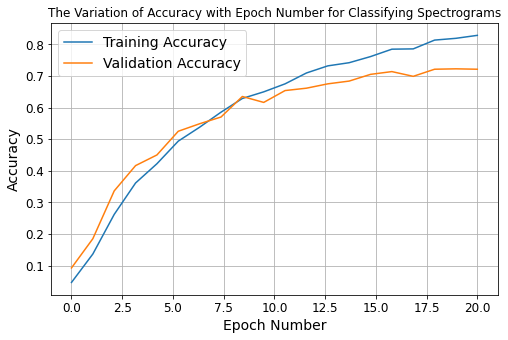

In [10]:
#Plotting the training and validation accuracies per epoch from the model training history

plt.figure(figsize=(8, 5))

plt.plot(np.linspace(0, 20, 20), history.history["accuracy"], label="Training Accuracy")
plt.plot(np.linspace(0, 20, 20), history.history["val_accuracy"], label="Validation Accuracy")

plt.tick_params(axis='x', labelsize=12)
plt.tick_params(axis='y', labelsize=12)

plt.xlabel("Epoch Number", size=14)
plt.ylabel("Accuracy", size=14)
plt.title("The Variation of Accuracy with Epoch Number for Classifying Spectrograms")
plt.legend(loc="best", fontsize=14)
plt.grid(True)
#plt.savefig("SpectrogramAccuracy.pdf", dpi=600, bbox_inches='tight')

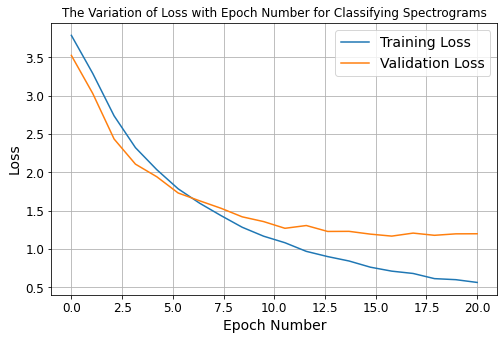

In [11]:
#Plotting the training and validation loss per epoch from the model training hsitory

plt.figure(figsize=(8, 5))

plt.plot(np.linspace(0, 20, 20), history.history["loss"], label="Training Loss")
plt.plot(np.linspace(0, 20, 20), history.history["val_loss"], label="Validation Loss")

plt.tick_params(axis='x', labelsize=12)
plt.tick_params(axis='y', labelsize=12)

plt.xlabel("Epoch Number", size=14)
plt.ylabel("Loss", size=14)
plt.title("The Variation of Loss with Epoch Number for Classifying Spectrograms")
plt.legend(loc="best", fontsize=14)
plt.grid(True)
#plt.savefig("SpectrogramLoss.pdf", dpi=600, bbox_inches='tight')

## Task 1 Conclusion
After 20 epochs of training, a validation/test accuracy of 72.12% was achieved. The validation accuracy seems to be variable (when running it multiple times) as the highest achieved was 76% (which i used in the report). Little divergence of validation accuracy from training accuracy is observed, which suggets the model is not over-fitting to the training dataset.

## Task 2
In this task we have to develop a machine learning algorithm to classify sounds from the ESC-50 dataset into 50 categories using wave-forms. The wave-forms are produced from the frequency-time data using the librosa python module.

Im going to classify the 1D wave-forms using a convolutional neural network with Conv1D layers.

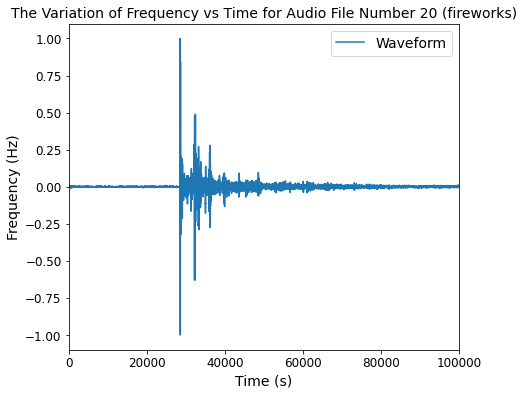

In [12]:
#Plotting the waveform representation of audio file number 20

plt.figure(figsize=(7, 6))
plt.plot(np.arange(signal.shape[0]), signal, label="Waveform")

plt.tick_params(axis='x', labelsize=12)
plt.tick_params(axis='y', labelsize=12)

plt.title("The Variation of Frequency vs Time for Audio File Number 20 (" + meta.category[20] +")", size=14)
plt.xlabel("Time (s)", size=14)
plt.xlim(0, 100000)
plt.ylabel("Frequency (Hz)", size=14)
plt.legend(loc="best", fontsize=14);

#plt.savefig("Waveform.pdf", dpi=600, bbox_inches='tight')

In [13]:
#Populating signal array with resized and normalised waveform data

signal_data = np.zeros((2000, 2205, 1))

for i in tqdm(range(0, 2000)):
    signal_spec = resize(preprocessing.normalize(getSignalSpect(meta, i)[0].reshape(-1, 1)), (2205, 1))
    signal_data[i] = signal_spec

100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [02:08<00:00, 15.54it/s]


In [14]:
#Generating signal data with noise

noisy_signal_data = signal_data + np.random.uniform(0, 0.1, signal_data.shape)
new_signal_data = np.concatenate((signal_data, noisy_signal_data), axis=0)

#Generating training and testing data
signal_train_data, signal_test_data, signal_train_labels, signal_test_labels = train_test_split(new_signal_data, labels, test_size=0.20, shuffle=True)

In [15]:
#Defining a 1D-CNN to classify the waveforms into 50 categories.

model2 = keras.Sequential([
    keras.layers.Input(shape=(2205, 1)),

    keras.layers.Conv1D(16, 3),
    keras.layers.LeakyReLU(),
    keras.layers.MaxPooling1D(2),

    keras.layers.Conv1D(32, 3),
    keras.layers.LeakyReLU(),
    keras.layers.MaxPooling1D(2),

    keras.layers.Conv1D(64, 3),
    keras.layers.LeakyReLU(),
    keras.layers.MaxPooling1D(2),

    keras.layers.Dropout(0.25),

    keras.layers.Flatten(),

    keras.layers.Dense(128),
    keras.layers.LeakyReLU(),

    keras.layers.Dropout(0.5),

    keras.layers.Dense(50)
])


#Compiling the model with a sparse categorical cross-entropy loss
model2.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), optimizer=keras.optimizers.Adam(learning_rate=1e-3), metrics=["accuracy"])

#Training the model for 20 epochs with a batchsize of 5
history2 = model2.fit(signal_train_data, signal_train_labels, epochs=20, batch_size=5, validation_data=(signal_test_data, signal_test_labels))

Epoch 1/20
640/640 [==============================] - 9s 13ms/step - loss: 3.5809 - accuracy: 0.1097 - val_loss: 3.0016 - val_accuracy: 0.2700
Epoch 2/20
640/640 [==============================] - 8s 13ms/step - loss: 2.0072 - accuracy: 0.4984 - val_loss: 1.7400 - val_accuracy: 0.6500
Epoch 3/20
640/640 [==============================] - 8s 13ms/step - loss: 0.7925 - accuracy: 0.8044 - val_loss: 1.4311 - val_accuracy: 0.7538
Epoch 4/20
640/640 [==============================] - 8s 13ms/step - loss: 0.4168 - accuracy: 0.9019 - val_loss: 1.5698 - val_accuracy: 0.7775
Epoch 5/20
640/640 [==============================] - 9s 13ms/step - loss: 0.3299 - accuracy: 0.9209 - val_loss: 1.6230 - val_accuracy: 0.8025
Epoch 6/20
640/640 [==============================] - 8s 13ms/step - loss: 0.2743 - accuracy: 0.9337 - val_loss: 1.7477 - val_accuracy: 0.8037
Epoch 7/20
640/640 [==============================] - 9s 13ms/step - loss: 0.1782 - accuracy: 0.9566 - val_loss: 1.9325 - val_accuracy: 0.8100

In [16]:
model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 2203, 16)          64        
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 2203, 16)          0         
                                                                 
 max_pooling1d (MaxPooling1D  (None, 1101, 16)         0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 1099, 32)          1568      
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 1099, 32)          0         
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 549, 32)          0         
 1D)                                                  

In [17]:
model2.evaluate(signal_test_data, signal_test_labels)

25/25 [==============================] - 0s 9ms/step - loss: 3.1172 - accuracy: 0.8025


[3.1171958446502686, 0.8025000095367432]

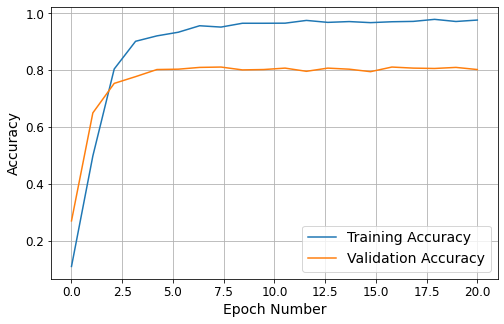

In [18]:
#Plotting the training and validation accuracy from the model training history

plt.figure(figsize=(8, 5))

plt.plot(np.linspace(0, 20, 20), history2.history["accuracy"], label="Training Accuracy")
plt.plot(np.linspace(0, 20, 20), history2.history["val_accuracy"], label="Validation Accuracy")

plt.tick_params(axis='x', labelsize=12)
plt.tick_params(axis='y', labelsize=12)

plt.xlabel("Epoch Number", size=14)
plt.ylabel("Accuracy", size=14)
#plt.title("The Variation of Accuracy with Epoch Number for Classifying Waveforms")
plt.legend(loc="best", fontsize=14)
plt.grid(True)
#plt.savefig("WaveformAccuracy.pdf", dpi=600, bbox_inches='tight')

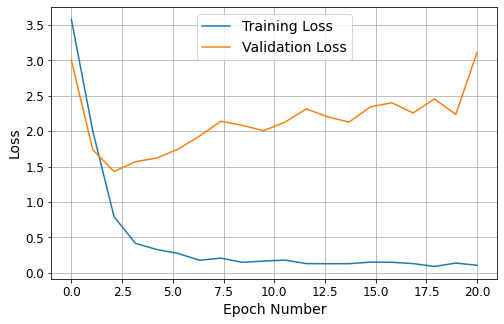

In [19]:
#Plotting the training and validation loss from the model training history

plt.figure(figsize=(8, 5))

plt.plot(np.linspace(0, 20, 20), history2.history["loss"], label="Training Loss")
plt.plot(np.linspace(0, 20, 20), history2.history["val_loss"], label="Validation Loss")

plt.tick_params(axis='x', labelsize=12)
plt.tick_params(axis='y', labelsize=12)

plt.xlabel("Epoch Number", size=14)
plt.ylabel("Loss", size=14)
#plt.title("The Variation of Loss with Epoch Number for Classifying Waveforms")
plt.legend(loc="best", fontsize=14)
plt.grid(True)
#plt.savefig("WaveformLoss.pdf", dpi=600, bbox_inches='tight')

## Task 2 Conclusion
After 20 epochs of training, a validation/test accuracy of 80.25% was achieved. Some divergence of validation accuracy from training accuracy is observed. This suggests that the model is slightly over-fitting to the training dataset. This could reduced by including more dropout layers.

## Task 3
This task is designed to determine which of the categories are easiest and hardest to separate. Firstly, I will analyse the data using the t-SNE algorithm to check for inherent features that could lead to a more easily categorisable dataset. Then I will generate confusion matrices which determine the categories which are easiest and  hardest to separate.

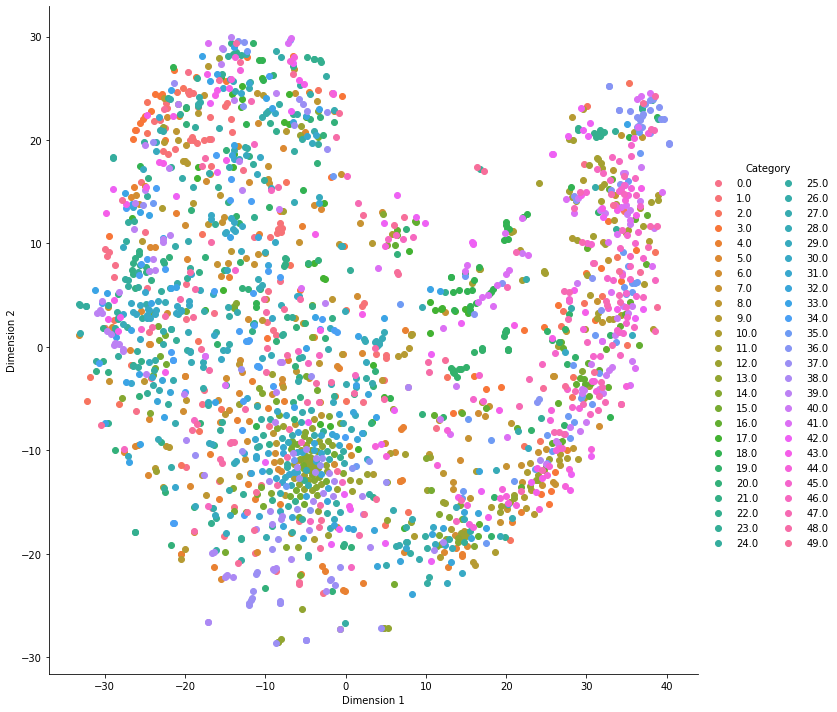

In [20]:
#Using the TSNE algorithm to see if the spectrograms with the same category are clustered together
#This could determine if our model will have a hard time classifying the spectrograms into categories

tsne = TSNE(n_components=2, random_state=0)

tsne_fit = tsne.fit_transform(data.reshape(-1, 128*128))
tsne_fit = np.column_stack((tsne_fit, np.array(meta.target)))

#Plotting the output data from the TSNE algorithm
df = pd.DataFrame(data=tsne_fit, columns=("Dimension 1", "Dimension 2", "Category"))
#sb.set(font_scale=2)
facet_grid = sb.FacetGrid(df, hue="Category", height=10, aspect=1)
facet_grid.map(plt.scatter, "Dimension 1", "Dimension 2")
facet_grid.add_legend(ncol=2);
#facet_grid.savefig("SpectrogramTSNE.pdf", dpi=600)

### Spectrogram t-SNE Comment

Some clustering is observed, but not enough to determine if the items in the spectrogram dataset have inherent features which make them more easily categorised.

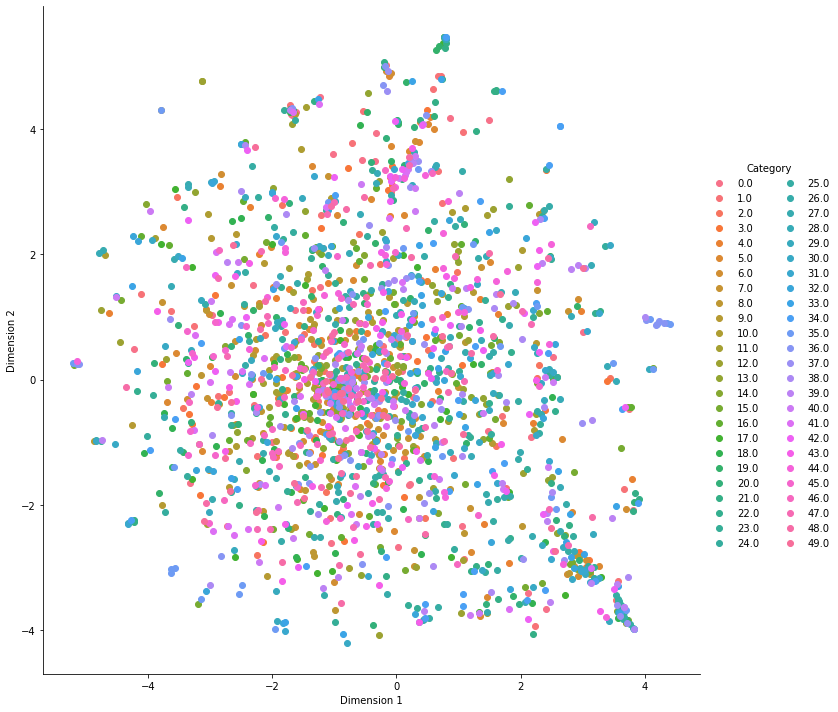

In [21]:
#Using the TSNE algorithm to see if the waveforms with the same category are clustered together
#This could determine if our model will have a hard time classifying the waveforms into categories

tsne_fit2 = tsne.fit_transform(signal_data.reshape(-1, 2205))
tsne_fit2 = np.column_stack((tsne_fit2, np.array(meta.target)))

#Plotting the output data from the TSNE algorithm
df2 = pd.DataFrame(data=tsne_fit2, columns=("Dimension 1", "Dimension 2", "Category")) 
facet_grid2 = sb.FacetGrid(df2, hue="Category", height=10, aspect=1)
facet_grid2.map(plt.scatter, "Dimension 1", "Dimension 2")
facet_grid2.add_legend(ncol=2);
#facet_grid2.savefig("WaveformTSNE.pdf", dpi=600)

### Spectrogram t-SNE Comment

No clustering is observed, so there are no inherent features which would make the items in the dataset more easily categorised.

In [22]:
#Generating model predictions from the spectrogram test data
pred = model.predict(test_data)
y_pred = np.array([np.argmax(pred[i]) for i in range(len(pred))])

25/25 [==============================] - 0s 8ms/step


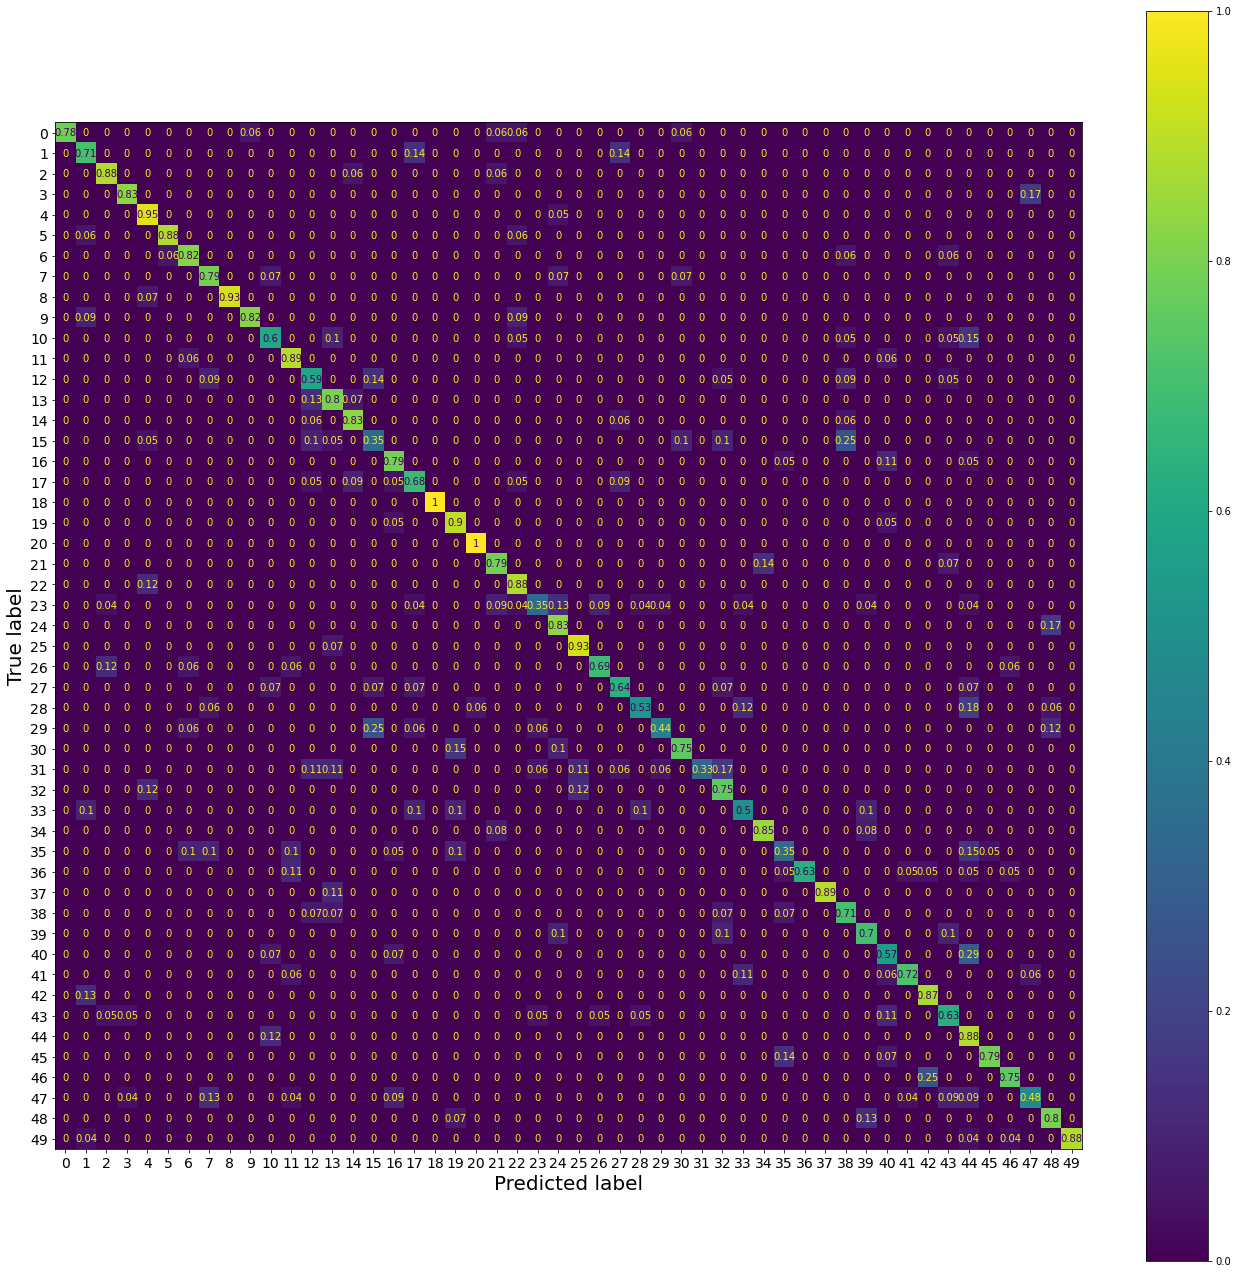

In [23]:
#Calculating a normalised confusion matrix from the sklearn library
conf_matrix = confusion_matrix(test_labels, y_pred) 
norm_conf_matrix = np.round(conf_matrix / conf_matrix.sum(axis=1)[:, np.newaxis], 2)

#Plotting the confusion matrix
figure = ConfusionMatrixDisplay(confusion_matrix=norm_conf_matrix)
fig, axes = plt.subplots(figsize=(23, 23))

axes.set_xlabel('Predicted Label', fontdict={"size":"20"})
axes.set_ylabel('True Label', fontdict={"size":"20"})
axes.tick_params(axis='both', which='major', labelsize=14)
plt.grid(False)
figure.plot(ax=axes)
#plt.savefig("SpectrogramConfusionMatrix.pdf", dpi=600, bbox_inches='tight')

### Spectrogram Confusion Matrix Comment
This consfusion matrix has different percentages to the one I included in the report. Every time I re-train my model, the validation accuracies change which in turn change the percentages in the confusion matrix. So I decided to pick the confusion matrix that was generated from a validation accuracy of 76% to include in my report. I refer you to my report to see the categories that are more easy and more difficult to categorise.

But purely looking at the confusion matrix above: toilet flush and crying baby are the more easily classifiable categories with a categorisation of 100%. The most difficult is mouse click at 33%.

In [24]:
#Generating model predictions from the spectrogram test data
pred2 = model2.predict(signal_test_data)
y_pred2 = np.array([np.argmax(pred2[i]) for i in range(len(pred2))])

25/25 [==============================] - 0s 8ms/step


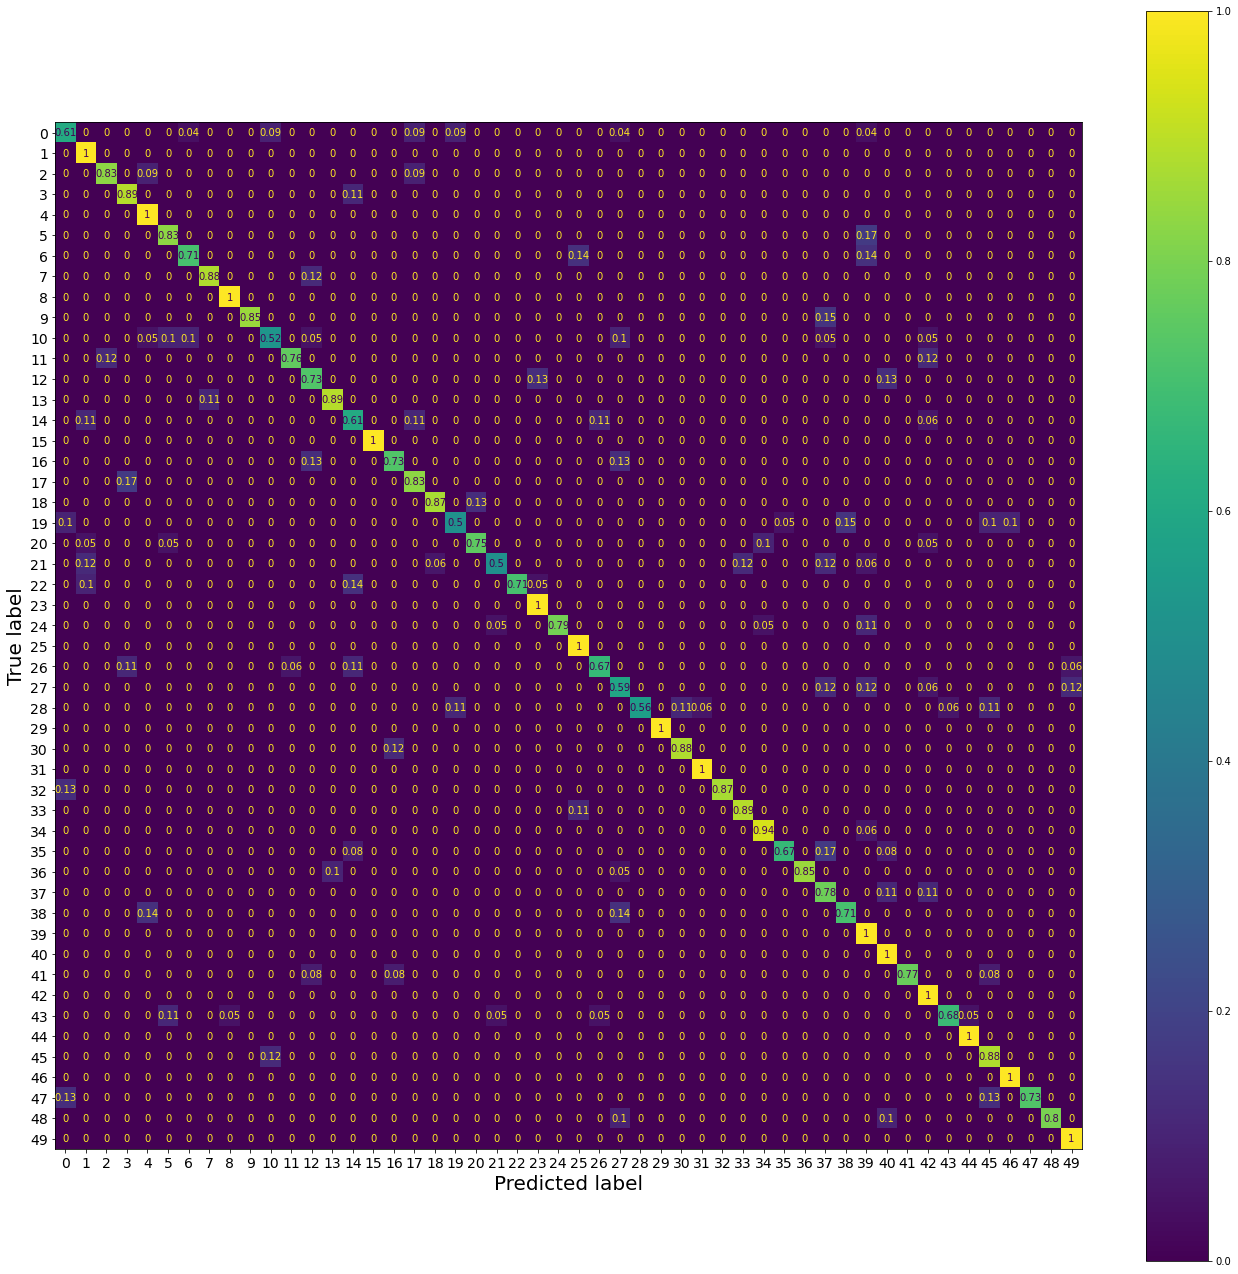

In [25]:
#Calculating a normalised confusion matrix from the sklearn library
conf_matrix2 = confusion_matrix(signal_test_labels, y_pred2) 
norm_conf_matrix2 = np.round(conf_matrix2 / conf_matrix2.sum(axis=1)[:, np.newaxis], 2)

#Plotting the confusion matrix
figure2 = ConfusionMatrixDisplay(confusion_matrix=norm_conf_matrix2)
fig2, axes2 = plt.subplots(figsize=(23, 23))

axes2.set_xlabel('Predicted Label', fontdict={"size":"20"})
axes2.set_ylabel('True Label', fontdict={"size":"20"})
axes2.tick_params(axis='both', which='major', labelsize=14)
plt.grid(False)
figure2.plot(ax=axes2)
#plt.savefig("WaveformConfusionMatrix.pdf", dpi=600, bbox_inches='tight')

### Waveform Confusion Matrix Comment
This consfusion matrix has different percentages to the one I included in the report. Every time I re-train my model, the validation accuracies change which in turn change the percentages in the confusion matrix. Hence, the categories that are more easily classifiable change. I refer you to my report to see the categories that are more easy and more difficult to categorise.

But purely looking at the confusion matrix above: rooster, frog, etc are the most easily classifiable categories with a categorisation of 100%. The hardest are thunderstorm and sneezing at 50% categorisation.